# Load in model

In [3]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification


# Download the model
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load in Sparse AE's

In [4]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
autoencoders = []
layers = model.config.num_hidden_layers
filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-attention-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(1,2)]
filenames = [item for sublist in filenames for item in sublist]
for filen in filenames:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    # Freeze autoencoder weights
    autoencoder.encoder.requires_grad_(False)
    autoencoder.encoder_bias.requires_grad_(False)
    autoencoders.append(autoencoder)
cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(1,2)]
cache_names = [item for sublist in cache_names for item in sublist]

# Load training data

In [5]:
# max_seq_length=80 # max length of per data point
# from datasets import load_dataset
# # dataset_name = "NeelNanda/pile-10k"
# dataset_name = "stas/openwebtext-10k"
# dataset = load_dataset(dataset_name, split="train").map(
#     lambda x: tokenizer(x['text']),
#     batched=True
# ).filter(
#     lambda x: len(x['input_ids']) > max_seq_length
# ).map(
#     lambda x: {'input_ids': x['input_ids'][:max_seq_length]}
# )

In [6]:
from activation_dataset import setup_token_data
from utils import dotdict

# Download the dataset
cfg = dotdict()

cfg.dataset_name="stas/openwebtext-10k"
cfg.max_length = 256
cfg.model_batch_size = 4
dataset = setup_token_data(cfg, tokenizer, model)
num_tokens = cfg.max_length*cfg.model_batch_size*len(dataset)
print(f"Number of tokens: {num_tokens}")

Found cached dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-89f7d956ed9de0f6_*_of_00008.arrow


Number of tokens: 11226112


## Model Definitions

In [7]:
from torch.optim import Adam
from torch import nn
class sparse_two_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x
    
class mlp(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class sparse_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

class linear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
    def forward(self, x):
        x = self.linear(x)
        return x
    
initialize_weights = False
num_features, d_model = autoencoder.encoder.shape
two_nonlinear_weights = []
mlp_weights = []
nonlinear_weights = []
linear_weights = []

two_nonlinear_optimizers = []
mlp_optimizers = []
nonlinear_optimizers = []
linear_optimizers = []
for auto_ind in range(len(autoencoders)//2):
    two_nonlinear_weights.append(sparse_two_nonlinear(num_features))
    two_nonlinear_weights[-1].to(device)
    two_nonlinear_optimizers.append(Adam(two_nonlinear_weights[-1].parameters(), lr=1e-3))

    mlp_weights.append(mlp(num_features))
    mlp_weights[-1].to(device)
    mlp_optimizers.append(Adam(mlp_weights[-1].parameters(), lr=1e-3))

    nonlinear_weights.append(sparse_nonlinear(num_features))
    nonlinear_weights[-1].to(device)
    nonlinear_optimizers.append(Adam(nonlinear_weights[-1].parameters(), lr=1e-3))

    linear_weights.append(linear(num_features))
    linear_weights[-1].to(device)
    linear_optimizers.append(Adam(linear_weights[-1].parameters(), lr=1e-3))

    if(initialize_weights):
        # Multiply the decoder weights by mlp weights & second autoencoder's encoder weights
        decoder = autoencoders[auto_ind].encoder
        mlp_enc = model.gpt_neox.layers[auto_ind+1].mlp.dense_h_to_4h.weight.detach().T
        mlp_dec = model.gpt_neox.layers[auto_ind+1].mlp.dense_4h_to_h.weight.detach().T
        encoder = autoencoders[auto_ind+1].encoder.T
        initial_weights = decoder @ mlp_enc @ mlp_dec @ encoder
        nonlinear_weights[-1].linear.weight.data = initial_weights
        linear_weights[-1].linear.weight.data = initial_weights

## Train the model

In [8]:
from baukit import TraceDict

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    l1_alpha = 1e-3
    batch_size = 32
    losses = [[] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            x_hat = sparse_weights[cache_name_ind](input_internal_activations)

            loss = mse(x_hat, output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha * l1_loss

            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind].append(loss.item())

            if i % 100 == 0:
                print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")
            
        if i > 500:
            # Stop training after 1000 batches
            break
    return losses
two_nonlinear_losses = train_sparse_model(model, dataset, device, two_nonlinear_weights, autoencoders, cache_names, two_nonlinear_optimizers)
mlp_losses = train_sparse_model(model, dataset, device, mlp_weights, autoencoders, cache_names, mlp_optimizers)

nonlinear_losses = train_sparse_model(model, dataset, device, nonlinear_weights, autoencoders, cache_names, nonlinear_optimizers)
linear_losses = train_sparse_model(model, dataset, device, linear_weights, autoencoders, cache_names, linear_optimizers)

  0%|          | 1/10963 [00:00<1:58:43,  1.54it/s]

Layers: 0 | MSE Loss: 0.001686643692664802 | L1 Loss: 27.717357635498047
Layers: 1 | MSE Loss: 0.015113798901438713 | L1 Loss: 27.718490600585938
Layers: 2 | MSE Loss: 0.009320104494690895 | L1 Loss: 27.72151756286621
Layers: 3 | MSE Loss: 0.027003802359104156 | L1 Loss: 27.70575523376465
Layers: 4 | MSE Loss: 1.049959421157837 | L1 Loss: 27.71478843688965


  1%|          | 101/10963 [00:16<29:28,  6.14it/s]

Layers: 0 | MSE Loss: 0.0009367442689836025 | L1 Loss: 29.47113037109375
Layers: 1 | MSE Loss: 0.00370907224714756 | L1 Loss: 33.84989929199219
Layers: 2 | MSE Loss: 0.0029816171154379845 | L1 Loss: 33.32650375366211
Layers: 3 | MSE Loss: 0.005088535603135824 | L1 Loss: 33.333736419677734
Layers: 4 | MSE Loss: 0.04910187050700188 | L1 Loss: 44.818138122558594


  2%|▏         | 201/10963 [00:33<29:03,  6.17it/s]

Layers: 0 | MSE Loss: 0.0008973879157565534 | L1 Loss: 30.86971092224121
Layers: 1 | MSE Loss: 0.003732516197487712 | L1 Loss: 36.10184860229492
Layers: 2 | MSE Loss: 0.0028660008683800697 | L1 Loss: 35.943695068359375
Layers: 3 | MSE Loss: 0.004116947762668133 | L1 Loss: 35.507747650146484
Layers: 4 | MSE Loss: 0.027947664260864258 | L1 Loss: 45.10002136230469


  3%|▎         | 301/10963 [00:49<28:59,  6.13it/s]

Layers: 0 | MSE Loss: 0.0009683420648798347 | L1 Loss: 32.062164306640625
Layers: 1 | MSE Loss: 0.0038901239167898893 | L1 Loss: 38.199371337890625
Layers: 2 | MSE Loss: 0.0029271463863551617 | L1 Loss: 38.326416015625
Layers: 3 | MSE Loss: 0.004845078103244305 | L1 Loss: 37.295738220214844
Layers: 4 | MSE Loss: 0.027189072221517563 | L1 Loss: 45.58352279663086


  4%|▎         | 401/10963 [01:05<28:58,  6.07it/s]

Layers: 0 | MSE Loss: 0.000922472623642534 | L1 Loss: 33.18626403808594
Layers: 1 | MSE Loss: 0.0036710265558212996 | L1 Loss: 40.161128997802734
Layers: 2 | MSE Loss: 0.002699975622817874 | L1 Loss: 40.52778625488281
Layers: 3 | MSE Loss: 0.004332771524786949 | L1 Loss: 39.02508544921875
Layers: 4 | MSE Loss: 0.028238382190465927 | L1 Loss: 46.625892639160156


  5%|▍         | 501/10963 [01:22<28:42,  6.07it/s]

Layers: 0 | MSE Loss: 0.001094073406420648 | L1 Loss: 34.16630172729492
Layers: 1 | MSE Loss: 0.0031463024206459522 | L1 Loss: 42.32255554199219
Layers: 2 | MSE Loss: 0.0034450353123247623 | L1 Loss: 42.75429916381836
Layers: 3 | MSE Loss: 0.004845039919018745 | L1 Loss: 40.693294525146484
Layers: 4 | MSE Loss: 0.025300845503807068 | L1 Loss: 47.82307052612305


  0%|          | 1/10963 [00:00<31:24,  5.82it/s]

Layers: 0 | MSE Loss: 0.001792849856428802 | L1 Loss: 27.70667266845703
Layers: 1 | MSE Loss: 0.0165414996445179 | L1 Loss: 27.71279525756836
Layers: 2 | MSE Loss: 0.011113815009593964 | L1 Loss: 27.708072662353516
Layers: 3 | MSE Loss: 0.02856592833995819 | L1 Loss: 27.712600708007812
Layers: 4 | MSE Loss: 0.9638112783432007 | L1 Loss: 27.711807250976562


  1%|          | 101/10963 [00:16<30:28,  5.94it/s]

Layers: 0 | MSE Loss: 0.0006128781824372709 | L1 Loss: 27.084476470947266
Layers: 1 | MSE Loss: 0.0014617046108469367 | L1 Loss: 31.180328369140625
Layers: 2 | MSE Loss: 0.002152516506612301 | L1 Loss: 30.41729736328125
Layers: 3 | MSE Loss: 0.003546179039403796 | L1 Loss: 31.883405685424805
Layers: 4 | MSE Loss: 0.032005973160266876 | L1 Loss: 43.89232635498047


  2%|▏         | 201/10963 [00:33<30:24,  5.90it/s]

Layers: 0 | MSE Loss: 0.0004258443950675428 | L1 Loss: 28.39612579345703
Layers: 1 | MSE Loss: 0.0009886318584904075 | L1 Loss: 33.11265563964844
Layers: 2 | MSE Loss: 0.0017298412276431918 | L1 Loss: 32.29357147216797
Layers: 3 | MSE Loss: 0.0027932419907301664 | L1 Loss: 35.055973052978516
Layers: 4 | MSE Loss: 0.02050461620092392 | L1 Loss: 44.17991638183594


  3%|▎         | 301/10963 [00:50<30:14,  5.88it/s]

Layers: 0 | MSE Loss: 0.0003534422430675477 | L1 Loss: 29.527713775634766
Layers: 1 | MSE Loss: 0.0006290904711931944 | L1 Loss: 34.725502014160156
Layers: 2 | MSE Loss: 0.00137309858109802 | L1 Loss: 33.812870025634766
Layers: 3 | MSE Loss: 0.0020383219234645367 | L1 Loss: 37.15604782104492
Layers: 4 | MSE Loss: 0.012196267023682594 | L1 Loss: 44.614418029785156


  4%|▎         | 401/10963 [01:07<30:00,  5.87it/s]

Layers: 0 | MSE Loss: 0.00037802912993356586 | L1 Loss: 30.559255599975586
Layers: 1 | MSE Loss: 0.0007982221432030201 | L1 Loss: 36.31022644042969
Layers: 2 | MSE Loss: 0.0013747999910265207 | L1 Loss: 35.18369674682617
Layers: 3 | MSE Loss: 0.0021586082875728607 | L1 Loss: 39.00703430175781
Layers: 4 | MSE Loss: 0.015417850576341152 | L1 Loss: 45.48273468017578


  5%|▍         | 501/10963 [01:24<29:49,  5.85it/s]

Layers: 0 | MSE Loss: 0.0003568180254660547 | L1 Loss: 31.527389526367188
Layers: 1 | MSE Loss: 0.0007828722009435296 | L1 Loss: 37.621559143066406
Layers: 2 | MSE Loss: 0.0013630043249577284 | L1 Loss: 36.63898849487305
Layers: 3 | MSE Loss: 0.002079946920275688 | L1 Loss: 40.60063552856445
Layers: 4 | MSE Loss: 0.013150965794920921 | L1 Loss: 46.57970428466797


  0%|          | 2/10963 [00:00<19:25,  9.40it/s]

Layers: 0 | MSE Loss: 0.0028544224333018064 | L1 Loss: 27.709396362304688
Layers: 1 | MSE Loss: 0.020244285464286804 | L1 Loss: 27.717662811279297
Layers: 2 | MSE Loss: 0.017510168254375458 | L1 Loss: 27.71023941040039
Layers: 3 | MSE Loss: 0.03975076600909233 | L1 Loss: 27.711795806884766
Layers: 4 | MSE Loss: 1.0382168292999268 | L1 Loss: 27.717880249023438


  1%|          | 101/10963 [00:09<16:47, 10.78it/s]

Layers: 0 | MSE Loss: 0.0012725431006401777 | L1 Loss: 24.932125091552734
Layers: 1 | MSE Loss: 0.013966843485832214 | L1 Loss: 26.785919189453125
Layers: 2 | MSE Loss: 0.00443878723308444 | L1 Loss: 29.428203582763672
Layers: 3 | MSE Loss: 0.011870842427015305 | L1 Loss: 29.379688262939453
Layers: 4 | MSE Loss: 0.9374852180480957 | L1 Loss: 30.37887191772461


  2%|▏         | 201/10963 [00:18<16:37, 10.79it/s]

Layers: 0 | MSE Loss: 0.0010450505651533604 | L1 Loss: 25.12001609802246
Layers: 1 | MSE Loss: 0.011178123764693737 | L1 Loss: 27.73855209350586
Layers: 2 | MSE Loss: 0.003333055879920721 | L1 Loss: 32.03325653076172
Layers: 3 | MSE Loss: 0.007266390137374401 | L1 Loss: 31.139053344726562
Layers: 4 | MSE Loss: 0.8583660125732422 | L1 Loss: 32.44296646118164


  3%|▎         | 301/10963 [00:27<16:30, 10.77it/s]

Layers: 0 | MSE Loss: 0.0009518526494503021 | L1 Loss: 25.620037078857422
Layers: 1 | MSE Loss: 0.010139917954802513 | L1 Loss: 28.740087509155273
Layers: 2 | MSE Loss: 0.0026022554375231266 | L1 Loss: 34.622962951660156
Layers: 3 | MSE Loss: 0.005470988806337118 | L1 Loss: 32.90928268432617
Layers: 4 | MSE Loss: 0.8720023036003113 | L1 Loss: 34.213417053222656


  4%|▎         | 401/10963 [00:37<16:20, 10.77it/s]

Layers: 0 | MSE Loss: 0.0009503748151473701 | L1 Loss: 26.19928741455078
Layers: 1 | MSE Loss: 0.00830069836229086 | L1 Loss: 29.6331844329834
Layers: 2 | MSE Loss: 0.002365578431636095 | L1 Loss: 36.853790283203125
Layers: 3 | MSE Loss: 0.0046247076243162155 | L1 Loss: 34.52934265136719
Layers: 4 | MSE Loss: 0.6349278688430786 | L1 Loss: 35.7510986328125


  5%|▍         | 501/10963 [00:46<16:13, 10.74it/s]


Layers: 0 | MSE Loss: 0.0007761379238218069 | L1 Loss: 26.788860321044922
Layers: 1 | MSE Loss: 0.007682971190661192 | L1 Loss: 30.437719345092773
Layers: 2 | MSE Loss: 0.0019094154704362154 | L1 Loss: 38.82688903808594
Layers: 3 | MSE Loss: 0.004318973980844021 | L1 Loss: 36.03083801269531
Layers: 4 | MSE Loss: 0.6607319116592407 | L1 Loss: 37.038352966308594


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.003786759451031685 | L1 Loss: 27.713024139404297
Layers: 1 | MSE Loss: 0.019457144662737846 | L1 Loss: 27.71286392211914


  0%|          | 2/10963 [00:00<17:23, 10.50it/s]

Layers: 2 | MSE Loss: 0.023639729246497154 | L1 Loss: 27.716854095458984
Layers: 3 | MSE Loss: 0.04493842273950577 | L1 Loss: 27.722000122070312
Layers: 4 | MSE Loss: 1.0217070579528809 | L1 Loss: 27.711334228515625


  1%|          | 102/10963 [00:09<16:56, 10.68it/s]

Layers: 0 | MSE Loss: 0.001116498140618205 | L1 Loss: 7.907460689544678
Layers: 1 | MSE Loss: 0.012350749224424362 | L1 Loss: 6.610256195068359
Layers: 2 | MSE Loss: 0.004940311424434185 | L1 Loss: 10.300634384155273
Layers: 3 | MSE Loss: 0.011583911255002022 | L1 Loss: 15.940581321716309
Layers: 4 | MSE Loss: 0.8699630498886108 | L1 Loss: 10.850298881530762


  2%|▏         | 202/10963 [00:18<16:53, 10.62it/s]

Layers: 0 | MSE Loss: 0.0009999991161748767 | L1 Loss: 6.322704315185547
Layers: 1 | MSE Loss: 0.011591074988245964 | L1 Loss: 5.365855693817139
Layers: 2 | MSE Loss: 0.003579455893486738 | L1 Loss: 10.359506607055664
Layers: 3 | MSE Loss: 0.007183663547039032 | L1 Loss: 15.412820816040039
Layers: 4 | MSE Loss: 0.8043787479400635 | L1 Loss: 9.2334623336792


  3%|▎         | 302/10963 [00:28<16:38, 10.68it/s]

Layers: 0 | MSE Loss: 0.0009051858214661479 | L1 Loss: 6.40289831161499
Layers: 1 | MSE Loss: 0.008693787269294262 | L1 Loss: 6.5761566162109375
Layers: 2 | MSE Loss: 0.002911728573963046 | L1 Loss: 11.129247665405273
Layers: 3 | MSE Loss: 0.0055290525779128075 | L1 Loss: 15.866957664489746
Layers: 4 | MSE Loss: 0.760324239730835 | L1 Loss: 10.31112289428711


  4%|▎         | 402/10963 [00:37<16:29, 10.68it/s]

Layers: 0 | MSE Loss: 0.0008259419701062143 | L1 Loss: 5.959677696228027
Layers: 1 | MSE Loss: 0.008202564902603626 | L1 Loss: 5.396256923675537
Layers: 2 | MSE Loss: 0.0024087335914373398 | L1 Loss: 10.045511245727539
Layers: 3 | MSE Loss: 0.004688382614403963 | L1 Loss: 14.957712173461914
Layers: 4 | MSE Loss: 0.6707622408866882 | L1 Loss: 9.226305961608887


  5%|▍         | 501/10963 [00:47<16:23, 10.64it/s]

Layers: 0 | MSE Loss: 0.0007698509725742042 | L1 Loss: 5.8696818351745605
Layers: 1 | MSE Loss: 0.006596948020160198 | L1 Loss: 5.042742729187012
Layers: 2 | MSE Loss: 0.0022004113998264074 | L1 Loss: 9.528929710388184
Layers: 3 | MSE Loss: 0.004275716841220856 | L1 Loss: 14.78421688079834
Layers: 4 | MSE Loss: 0.5801042318344116 | L1 Loss: 9.467844009399414


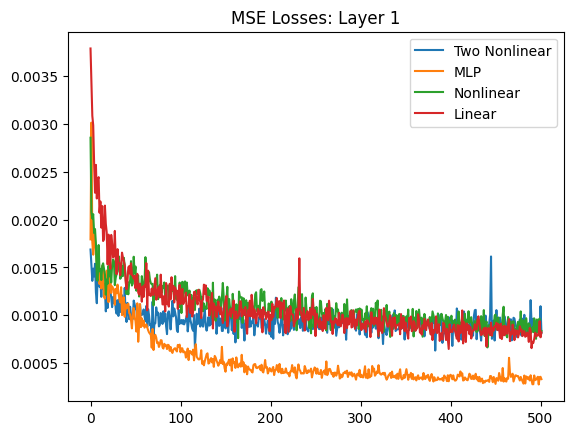

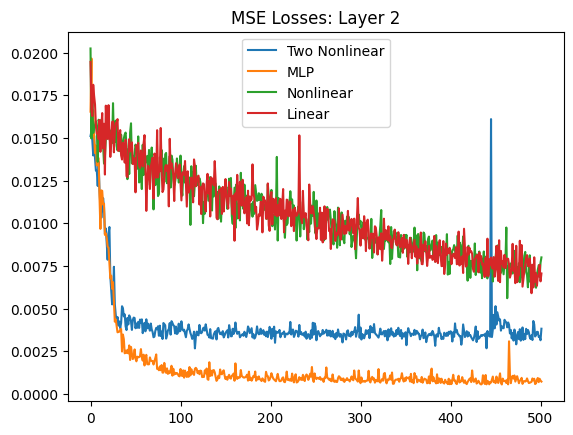

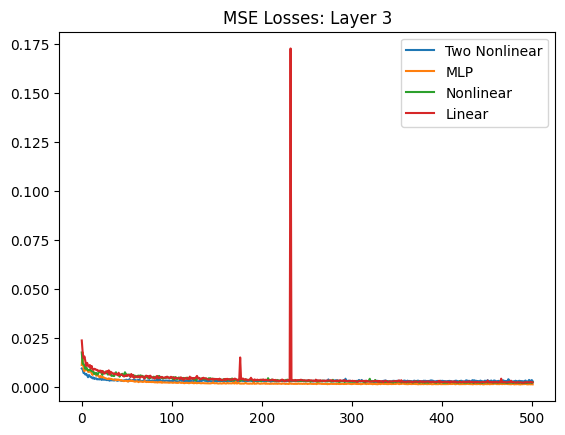

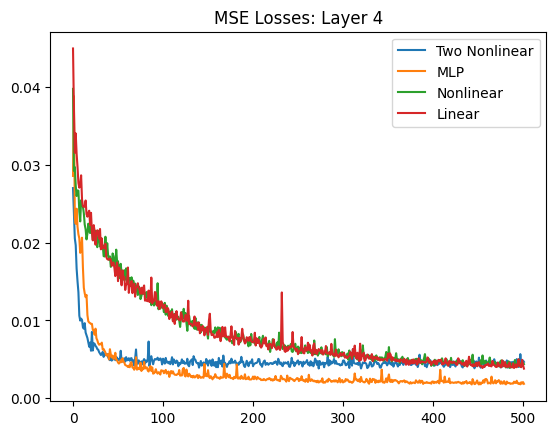

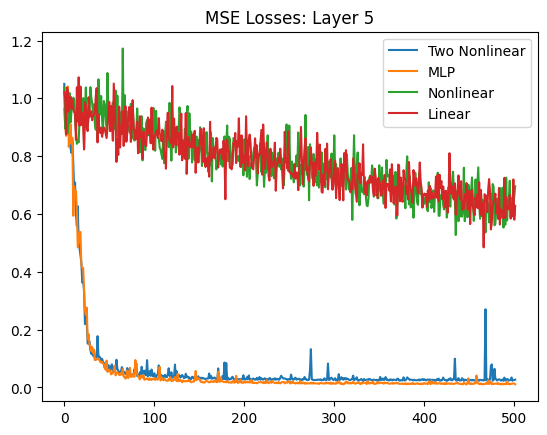

In [9]:
# Plot both losses
import matplotlib.pyplot as plt
for layer in range(len(two_nonlinear_losses)):
    # make a new plot
    plt.figure()
    plt.title(f"MSE Losses: Layer {layer+1}")
    plt.plot(two_nonlinear_losses[layer])
    plt.plot(mlp_losses[layer])
    plt.plot(nonlinear_losses[layer])
    plt.plot(linear_losses[layer])
    plt.legend(["Two Nonlinear", "MLP", "Nonlinear", "Linear"])
plt.show()

In [33]:
# Get the losses for each feature
mse = nn.MSELoss(reduction="none")
l1_alpha = 1e-3
batch_size = 32

# with dataset.formatted_as("pt"):
#     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
max_batches = 1
loss_diff = torch.zeros((len(cache_names)//2, num_features))
# loss_diff = torch.zeros((len(cache_names)//2, 1024))
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            if(i == 0):
                # Print the norms of both input & output
                print(f"Layer: {cache_name_ind+1}")
                print(f"Input Norms: {input_internal_activations.norm(dim=1).mean()}")
                print(f"Output Norms: {output_internal_activations.norm(dim=1).mean()}")

                # Also check dead features
                print(f"Input Dead Features: {(input_internal_activations.count_nonzero(dim=0) == 0).sum()}")
                print(f"Output Dead Features: {(output_internal_activations.count_nonzero(dim=0) == 0).sum()}")

            x_hat_mlp = mlp_weights[cache_name_ind](input_internal_activations)
            x_hat_linear = linear_weights[cache_name_ind](input_internal_activations)
            
            # We want to compare the MLP loss & linear loss
            # for every feature, so we mean the batch & pos, but not the feature
            mlp_loss = mse(x_hat_mlp, output_internal_activations).mean(dim=0).cpu()
            linear_loss = mse(x_hat_linear, output_internal_activations).mean(dim=0).cpu()

            # instead of mse, do cosine sim
            # mlp_loss = torch.cosine_similarity(x_hat_mlp, output_internal_activations, dim=1).cpu()
            # linear_loss = torch.cosine_similarity(x_hat_linear, output_internal_activations, dim=1).cpu()
            loss_diff[cache_name_ind] += linear_loss - mlp_loss
        if(i >= max_batches):
            break
loss_diff /= max_batches

  0%|          | 1/10963 [00:00<45:36,  4.01it/s]

Layer: 1
Input Norms: 4.346586227416992
Output Norms: 1.7820091247558594
Input Dead Features: 2144
Output Dead Features: 2367
Layer: 2
Input Norms: 4.97184419631958
Output Norms: 3.226607322692871
Input Dead Features: 1614
Output Dead Features: 2484
Layer: 3
Input Norms: 6.949631690979004
Output Norms: 4.593523025512695
Input Dead Features: 1158
Output Dead Features: 1949
Layer: 4
Input Norms: 8.636276245117188
Output Norms: 7.59709358215332
Input Dead Features: 1575
Output Dead Features: 1726
Layer: 5
Input Norms: 9.24307632446289
Output Norms: 51.93138885498047
Input Dead Features: 953
Output Dead Features: 2617


tensor(1108, device='cuda:0')

In [11]:
mlp_loss, linear_loss.min()

(tensor([0.0202, 0.0003, 0.0018,  ..., 0.0003, 0.0003, 0.0004]),
 tensor(1.1571e-05))

In [12]:
torch.cosine_similarity(x_hat_mlp, output_internal_activations, dim=1).shape

torch.Size([1024])

In [13]:
output_internal_activations.shape

torch.Size([1024, 3072])

In [14]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


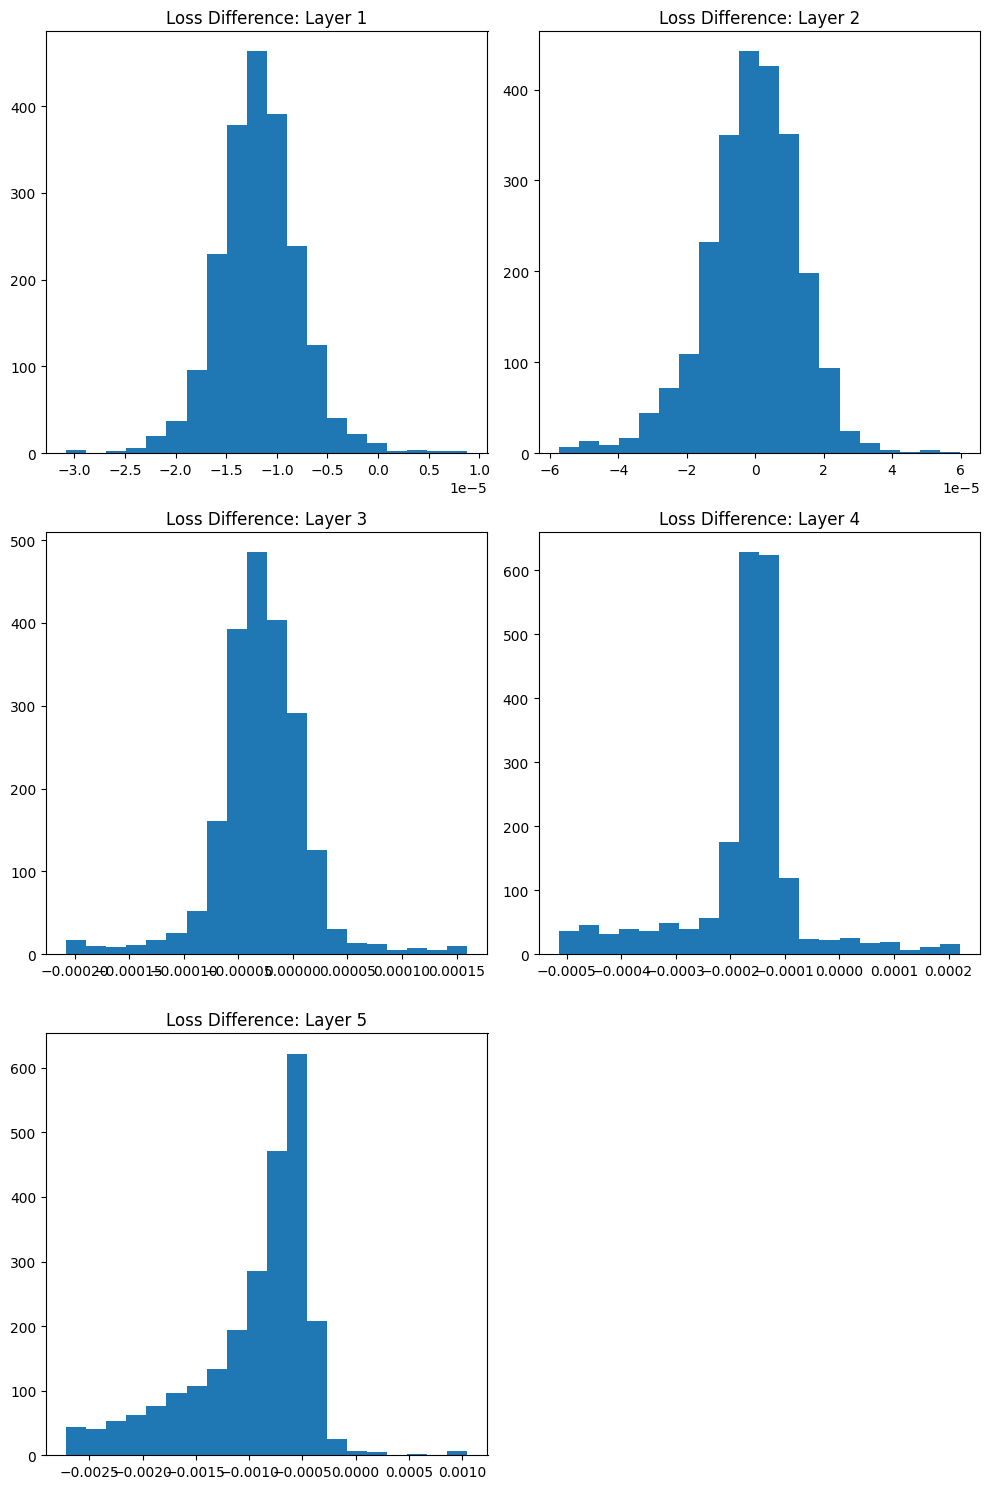

In [15]:
import matplotlib.pyplot as plt

num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy()
    filtered = loss_d[~is_outlier(loss_d)]
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.hist(filtered, bins = 20)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")

plt.tight_layout()
plt.show()


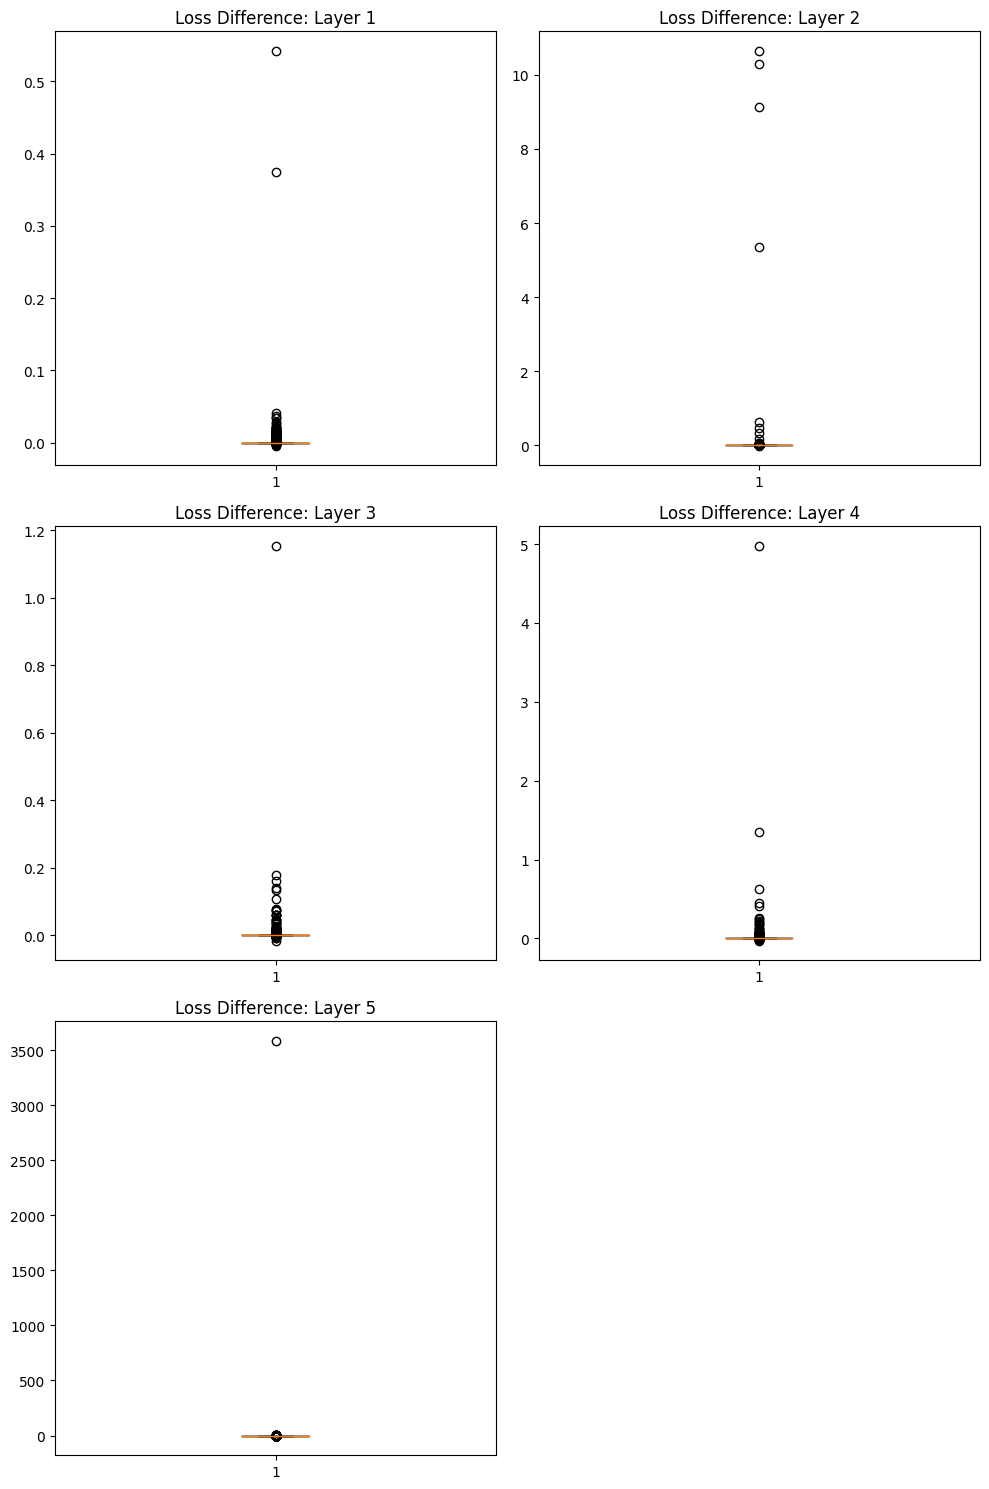

In [16]:
import matplotlib.pyplot as plt

num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy()
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.boxplot(loss_d)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")

plt.tight_layout()
plt.show()

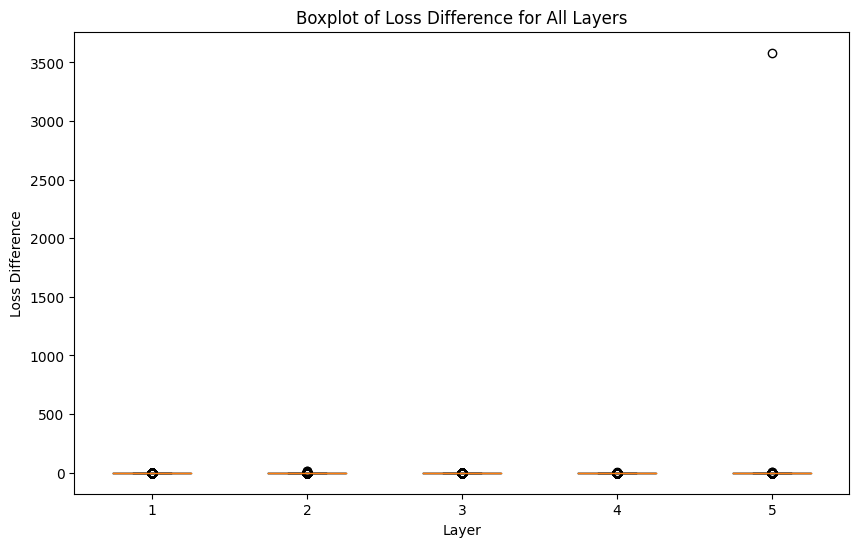

In [18]:
import matplotlib.pyplot as plt

# Collect all loss_diff data for each layer into a list
all_layers_loss_diff = [loss_diff[layer] for layer in range(len(loss_diff))]

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.boxplot(all_layers_loss_diff)
plt.title("Boxplot of Loss Difference for All Layers")
plt.xlabel("Layer")
plt.ylabel("Loss Difference")

plt.show()

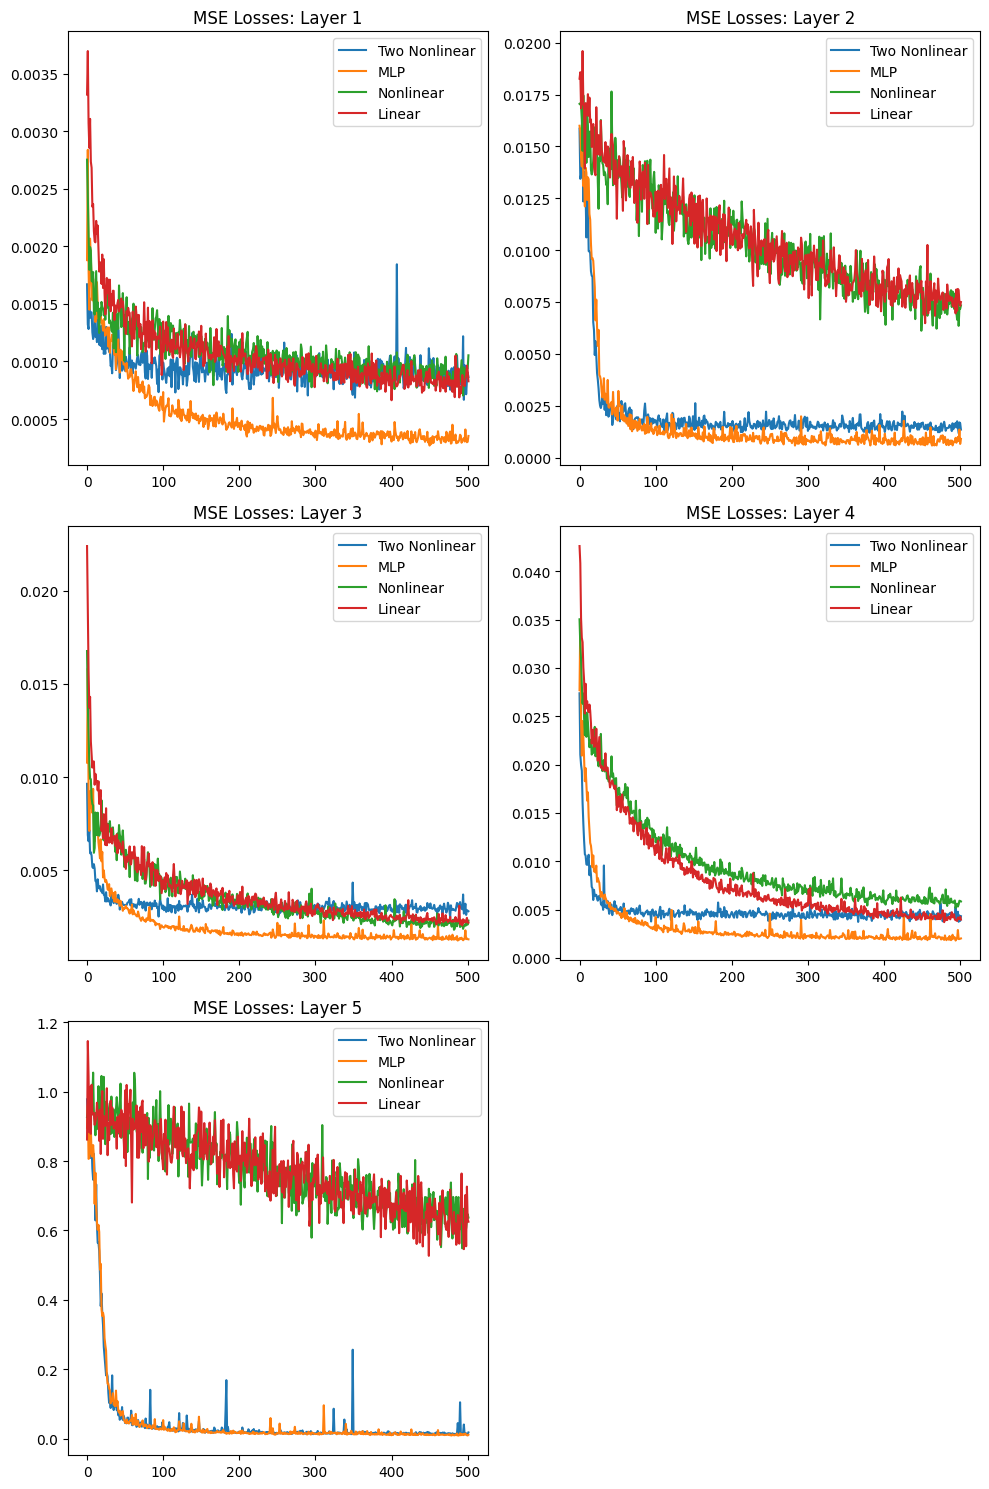

In [15]:
import matplotlib.pyplot as plt

num_layers = len(two_nonlinear_losses)
num_columns = 2  # You can adjust this based on how many plots you want per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"MSE Losses: Layer {layer+1}")
    plt.plot(two_nonlinear_losses[layer], label="Two Nonlinear")
    plt.plot(mlp_losses[layer], label="MLP")
    plt.plot(nonlinear_losses[layer], label="Nonlinear")
    plt.plot(linear_losses[layer], label="Linear")
    plt.legend()

plt.tight_layout()
plt.show()


In [24]:
nonlinear_losses, linear_loss

(array([0.00114306, 0.02376839, 0.00199088, 0.00503561, 0.70069301]),
 array([0.00112041, 0.02399791, 0.00216295, 0.00460967, 0.70566905]))

In [53]:
from baukit import TraceDict
mse = nn.MSELoss()
l1_alpha = 1e-3
datapoints = dataset.num_rows
batch_size = 32
losses = np.zeros(len(sparse_weights))
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(dl):
        batch = batch.to(device)
        with torch.no_grad():
            # Get LLM intermediate activations
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        # # Get every 2 cache names (since they're matched up)
        for cache_name_ind in range(len(cache_names)//2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[(cache_name_ind*2)]
            output_cache_name = cache_names[(cache_name_ind*2)+1]
            input_autoencoder = autoencoders[(cache_name_ind*2)]
            output_autoencoder = autoencoders[(cache_name_ind*2)+1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output
            # check if instance tuple ie a layer output
            if(isinstance(input_activations, tuple)):
                input_activations = input_activations[0]
            if(isinstance(output_activations, tuple)):
                output_activations = output_activations[0]
            # Rearrange to (batch_size*seq_length, num_features)
            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n" )
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n" )
            # Encode
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            # Encode
            x_hat = sparse_weights[cache_name_ind](input_internal_activations)
            # Get loss
            loss = mse(x_hat, output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha*l1_loss
            # Backprop
            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind] = loss.item()
            if(i%50==0):
                print(f"Layers: {cache_name_ind} |  MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")


Layers: 0 |  MSE Loss: 0.0032902932725846767 | L1 Loss: 27.721176147460938
Layers: 1 |  MSE Loss: 0.045880552381277084 | L1 Loss: 27.712087631225586
Layers: 2 |  MSE Loss: 0.02548954077064991 | L1 Loss: 27.71087646484375
Layers: 3 |  MSE Loss: 0.0651974007487297 | L1 Loss: 27.717008590698242
Layers: 4 |  MSE Loss: 0.8611162900924683 | L1 Loss: 27.709190368652344
Layers: 0 |  MSE Loss: 0.001719774678349495 | L1 Loss: 24.83885955810547
Layers: 1 |  MSE Loss: 0.038391195237636566 | L1 Loss: 26.483190536499023
Layers: 2 |  MSE Loss: 0.0042221806943416595 | L1 Loss: 28.59328269958496
Layers: 3 |  MSE Loss: 0.02699713036417961 | L1 Loss: 28.991947174072266
Layers: 4 |  MSE Loss: 0.8554728031158447 | L1 Loss: 29.95911979675293
Layers: 0 |  MSE Loss: 0.0017383686499670148 | L1 Loss: 24.861730575561523
Layers: 1 |  MSE Loss: 0.035102322697639465 | L1 Loss: 26.954181671142578
Layers: 2 |  MSE Loss: 0.0031695878133177757 | L1 Loss: 29.906362533569336
Layers: 3 |  MSE Loss: 0.018583638593554497 | 

In [55]:
losses_mlp, losses

# See if the top weights have high cosine similarity between the two

In [13]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
# for f_out, f_in in indices:
    # Find the cosine similarity between these two vectors

dict_in = autoencoders[0].get_learned_dict()
dict_out = autoencoders[1].get_learned_dict()


In [1]:
# f2 = ReLU(w*f1 + b)
'''
d1= [f_0, f_1]

w = [w00, w01]
    [w10, w11]

f2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]
'''

'\nd1= [f_0, f_1]\n\nw = [w00, w01]\n    [w10, w11]\n\nf2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]\n'

In [24]:
squished = Sparse_nonlinear.linear.weight.detach().flatten()
top_val, top_ind = torch.topk(squished, 10)
row_ind = top_ind//num_features
col_ind = top_ind%num_features
# Row is output feature index
# Col is input feature index
top_val, row_ind, col_ind

(tensor([0.3108, 0.3100, 0.3035, 0.3032, 0.3001, 0.2986, 0.2986, 0.2979, 0.2974,
         0.2940], device='cuda:0'),
 tensor([2390, 2863, 2390, 1224, 2863, 1224, 1582, 2863, 1582, 1582],
        device='cuda:0'),
 tensor([3028, 3028,  247,  247,  887,  887,  887, 1904,  247,   67],
        device='cuda:0'))

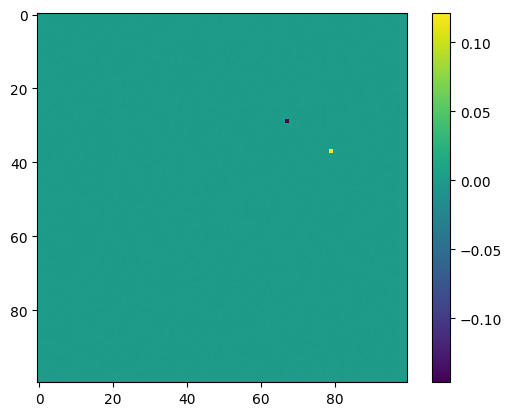

In [25]:
# Plot weight matrix as image
import matplotlib.pyplot as plt
plt.imshow(Sparse_nonlinear.linear.weight[:100,:100].detach().cpu())
plt.colorbar()
plt.show()

In [33]:
threshold_pos = 0.1
threshold_neg = -0.1
total_weights = Sparse_nonlinear.linear.weight.numel()
(Sparse_nonlinear.linear.weight > threshold_pos).count_nonzero() / total_weights, (Sparse_nonlinear.linear.weight < threshold_neg).count_nonzero() / total_weights, total_weights

(tensor(0.0002, device='cuda:0'), tensor(0.0001, device='cuda:0'), 9437184)

In [35]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
indices, Sparse_nonlinear.linear.weight[indices[:,0], indices[:,1]]

(tensor([[   1, 2191],
         [  11,  596],
         [  11, 1184],
         ...,
         [3059, 2127],
         [3059, 3066],
         [3065, 2497]], device='cuda:0'),
 tensor([0.1686, 0.1715, 0.1995,  ..., 0.2472, 0.1418, 0.1529], device='cuda:0',
        grad_fn=<IndexBackward0>))

In [38]:
indices[:10]

tensor([[   1, 2191],
        [  11,  596],
        [  11, 1184],
        [  11, 2676],
        [  14, 2468],
        [  19, 1166],
        [  20,  719],
        [  28,  232],
        [  28,  662],
        [  29, 1404]], device='cuda:0')

In [39]:
indices[10:20]

tensor([[  31, 2115],
        [  31, 2399],
        [  31, 3014],
        [  34, 2422],
        [  37,   79],
        [  37, 1885],
        [  89, 1323],
        [ 103,  837],
        [ 103, 2310],
        [ 105, 1565]], device='cuda:0')

In [40]:
indices[20:30]

tensor([[ 105, 2002],
        [ 105, 2697],
        [ 106,   67],
        [ 106,  146],
        [ 106,  189],
        [ 106,  247],
        [ 106,  330],
        [ 106,  344],
        [ 106,  458],
        [ 106,  690]], device='cuda:0')

In [14]:
f_ind = 1899
Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values, Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values

(tensor([0.0828, 0.0023, 0.0022, 0.0014, 0.0009], device='cuda:0',
        grad_fn=<TopkBackward0>),
 tensor([0.1980, 0.1734, 0.1371, 0.1282, 0.1280], device='cuda:0',
        grad_fn=<TopkBackward0>))

In [18]:
features = [11, 29, 203]
import matplotlib.pyplot as plt
for x in features:
    val = Sparse_nonlinear.linear.weight[x]
#     plt.hist(val.detach().cpu().numpy(), bins=50, label=f"Feature {x}")
    mean = val.mean()
    std = val.std()
    min = val.min()
    max = val.max()
    print(f"Feature {x}: mean: {mean}, std: {std}, min: {min}, max: {max}")
# plt.legend()
plt.show()

Feature 11: mean: 0.0001571535540279001, std: 0.00546741159632802, min: -0.10035543143749237, max: 0.16572602093219757
Feature 29: mean: -0.0004656702221836895, std: 0.011058892123401165, min: -0.2426990568637848, max: 0.15703199803829193
Feature 203: mean: 0.0017885728739202023, std: 0.03143875673413277, min: -0.22366595268249512, max: 0.2349885255098343


In [39]:
f_ind = 9
print("Dead Feature")
print(f"column: {Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values}")
print(f"Row: { Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values}")
    

Dead Feature
column: tensor([0.1078, 0.0246, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)
Row: tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)


In [31]:
# dictionary_activations[:100000].count_nonzero(0).count_nonzero(0)
dictionary_activations[:10000].count_nonzero(0).topk(10, largest=False), dictionary_activations[:10000].count_nonzero(0).topk(10, largest=True)

(torch.return_types.topk(
 values=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 indices=tensor([ 8,  9,  4,  7,  5,  3,  0, 10,  2,  6])),
 torch.return_types.topk(
 values=tensor([4094, 3426, 3297, 2861, 2722, 2140, 1370, 1369, 1354, 1084]),
 indices=tensor([1899,  203,  905,  260, 1773, 1191, 2863, 1224, 2390,  628])))

In [17]:
dictionary_activations.shape

torch.Size([297480, 3072])

In [9]:
from alpha_utils_interp import *
import os
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

# features = [1,2,3,4,5,6,7,8,9,10]
# features = [5,6]
# features = None
num_features = 30
feature = 0
input_setting = "input_only"
for _ in range(num_features):
    # Check if feature is dead (<10 activations)
    dead_threshold = 10
    # if(dictionary_activations[:, current_feature].count_nonzero() < dead_threshold):
    while(dictionary_activations[:, feature].count_nonzero() < dead_threshold):
        print(f"Feature {feature} is dead")
        feature += 1
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
    # get_token_statistics(feature, dictionary_activations[:, feature], dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)
    if(input_setting == "input_only"):
        # Calculate logit diffs on this feature for the full_token_list
        logit_diffs = ablate_feature_direction(model, full_token_list, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="sentences", model_type=model_type)
        # save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type)
        save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type, show=True)
        all_changed_activations = ablate_context_one_token_at_a_time(model, token_list, cache_name, autoencoder, feature, max_ablation_length=30)
        save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    else:
        logit_diffs = ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="dataset")
        _, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, tokenizer, max_seq_length, dataset)
        get_token_statistics(feature, logit_diffs, dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, setting="output", num_unique_tokens=10)
        save_token_display(full_token_list_ablated, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = full_activations_ablated)
    # if(ablate_context ==True):
    #     all_changed_activations = ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, max_ablation_length=20)
    #     save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    # combine_images(feature, setting=input_setting, ablate_context=ablate_context)
    feature += 1

100%|██████████| 310/310 [00:10<00:00, 29.77it/s]
/root/sparse_coding/alpha_utils_interp.py:349: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(best_feature_activations, bin_boundaries)


Feature 0 is dead


NameError: name 'model_type' is not defined

In [ ]:
Sparse_nonlinear.linear.weight[:, x].topk(10)

torch.return_types.topk(
values=tensor([0.0016, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0005], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([1899, 2168, 2598, 1191, 2841, 1595,  601, 2818,  905,  983],
       device='cuda:0'))

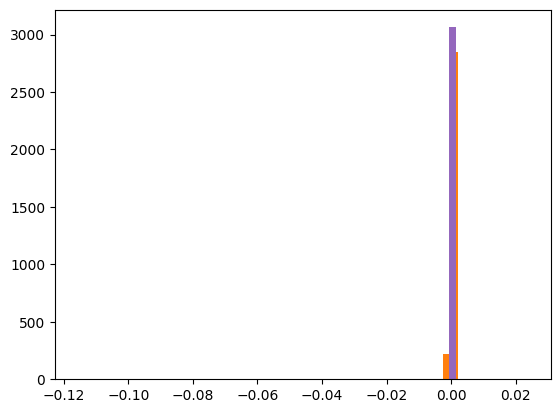

In [50]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[:, x]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

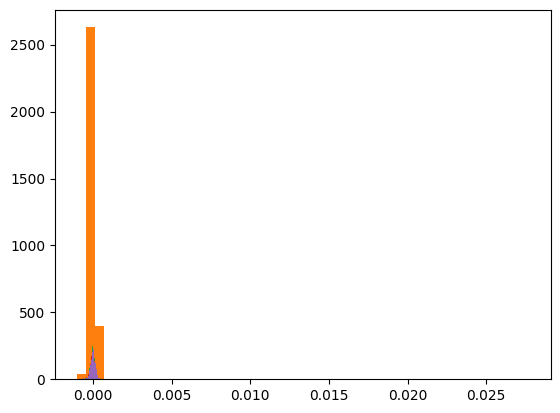

In [51]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[x, :]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

In [37]:
list(Sparse_nonlinear.parameters())

[Parameter containing:
 tensor([[ 0.0124, -0.0044, -0.0002,  ..., -0.0062, -0.0021,  0.0138],
         [ 0.0145, -0.0066, -0.0114,  ...,  0.0170,  0.0121, -0.0112],
         [-0.0014,  0.0121, -0.0046,  ..., -0.0161,  0.0043, -0.0040],
         ...,
         [-0.0075,  0.0023,  0.0118,  ..., -0.0031, -0.0092, -0.0004],
         [-0.0063,  0.0080,  0.0002,  ..., -0.0180, -0.0156,  0.0083],
         [ 0.0041,  0.0157, -0.0164,  ...,  0.0036,  0.0057, -0.0050]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0098, -0.0107,  0.0123,  ...,  0.0170,  0.0130,  0.0111],
        device='cuda:0', requires_grad=True)]

In [ ]:
Sparse_nonlinear.linear.weight.shape

In [ ]:
dictionary_activations[0].count_nonzero(dim=-1).float().mean()